# Introduction

This part of the demo shows a basic classification workflow: scaling the data, training the classifier and finally evaluating its performance. I'm using Dask for loading the data, distributing the computing across multiple processes and keeping memory usage under control. The Dask-ml library is an extra Dask library specifically for machine learning. It provides a few models like linear models, some preprocessing methods, incremental PCA, and distributed hyperparameter search (which is also memory efficient).

Each row has 55 values, 52 of which are features, and an associated fault number from 0 (no fault) to 20. The goal is to predict the fault number.

Scikit-learn provides the ML algorithms used in this demo, which Dask wraps with an incremental learning algorithm [dask_ml.wrappers.Incremental](https://ml.dask.org/modules/generated/dask_ml.wrappers.Incremental.html#dask_ml.wrappers.Incremental). This wrapper works with any class that implements the Sckit-learn `partial_fit` method, which is supported by several Scikit-learn classes in this [list of incremental learners](https://scikit-learn.org/stable/computing/scaling_strategies.html#incremental-learning). Dask-ml calls `partial_fit` for each block of the input data.

In [1]:
import os

import numpy as np

from matplotlib import pyplot as plt

from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler # Scale and shift each feature to have zero mean and standard deviation equal to one.
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import datashader as ds
from dask.distributed import Client
from dask import dataframe as ddf
from dask_ml.wrappers import Incremental

# Creating the Dask cluster

This creates a local cluster with four worker processes, each with one thread and 1GiB of memory. You can use multiple threads per worker, which results in a degree of parallelism, mostly in loading the data. However, this allows more RAM per process, which is useful for large blocks of data.

Passing `memory_limit='1GiB'` limits the RAM per process to 1GiB. If more than about 60% of this is used, Dask will start spilling **some** memory to disk. Dask distinguishes between managed an unmanaged memory. Managed memory is Python objeects, unmanaged memory is held by external non-python libraries. Managed memory can be spilled to disk and gets stored in a folder called `dask-worker-space`.

In [2]:
dask_client = Client(n_workers=4, threads_per_worker=1, memory_limit='1GiB')

# Prepare the data

## Loading the data

Here, Dask doesn't immediately load the HDF5 file, instead it creates a task graph. Assigning subsets of the data to `X_data` and `y_data` just adds to this task graph.

In [3]:
training_data = ddf.read_hdf('data/train.hdf', key='/train_*')

In [10]:
X_data = training_data.iloc[:, 3:]
y_data = training_data.faultNumber

## Preprocessing

`StandardScaler` calculates the mean and standard deviation of each feature. This executes each task in the task graph that defines how to load the data. Each block of the data is processed individually. This works really well because there's equations for calculating the mean and standard deviation incrementally.

Calling the `transform` method of the scaler doesn't transform the data, it creates a task graph. The transform tasks are only processed just before they're needed.

In [11]:
scaler = Incremental(StandardScaler(), scoring='accuracy')
scaler.fit(X_data, y_data)

Incremental(estimator=StandardScaler(), scoring='accuracy')

In [12]:
X_norm = scaler.transform(X_data)

# Classification

This isn't particularly difficult, just wrap the Scikit-learn classifier in `dask_ml.wrappers.Incremental` and call either `fit` or `partial_fit`. **NB:** You need to pass the `classes` parameter to provide a list of the class labels that exist in `y_data`. Normally, if you call `fit` on a Scikit-learn classifier, Scikit-learn would determine this list by using the NumPy function `unique`. That isn't possible with `partial_fit` since there's no guarantee that all of the labels are present in the first batch of data.

`dask_ml.wrappers.Incremental` provides both `fit` and `partial_fit` methods. The difference is that `fit` overwrites the previous classifier, while `partial_fit` starts with the previous classifier and just keeps on calling that classifier's `partial_fit` method. Why care? Both methods iterate through the data once. But, you really want to present the data multiple times in different orders until converging to some notion of good performance.

In [14]:
clf = Incremental(SGDClassifier(), scoring='accuracy')

In [15]:
for epoch in range(10):
    clf.partial_fit(X_norm, y_data, classes=list(range(21)))
    print(f'Epoch {epoch}: accuracy={clf.score(X_norm, y_data)}')

Epoch 0: accuracy=0.47190079207920793
Epoch 1: accuracy=0.45022158415841584
Epoch 2: accuracy=0.47912811881188117
Epoch 3: accuracy=0.48646554455445545
Epoch 4: accuracy=0.4716720792079208
Epoch 5: accuracy=0.4738051485148515
Epoch 6: accuracy=0.4755409900990099
Epoch 7: accuracy=0.4666837623762376
Epoch 8: accuracy=0.467560396039604
Epoch 9: accuracy=0.4803572277227723


# Testing

First, load the data and apply the standard scaler to it. The time that this takes is just the time to build up the task graph, no processing happens here. Processing only happens when we call the `score` and `predict` methods of the classifier.

In [17]:
testing_data = ddf.read_hdf('data/test.hdf', key='/test_*')
X_data_test = testing_data.iloc[:, 3:]
y_data_test = testing_data.faultNumber
X_norm_test = scaler.transform(X_data_test)

In [18]:
print(f'Test set accuracy: {clf.score(X_norm_test, y_data_test)}')

Test set accuracy: 0.48513632075471697


In [19]:
y_pred_dask = clf.predict(X_norm_test)
y_pred = y_pred_dask.astype(np.int64).compute() # scikit-learn's f1_score and classification_report functions don't tolerate Dask arrays :(

In [20]:
print(classification_report(y_data_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00    480000
           1       0.98      0.98      0.98    400000
           2       0.99      0.97      0.98    400000
           3       0.04      0.00      0.00    400000
           4       0.57      1.00      0.72    400000
           5       0.63      1.00      0.77    400000
           6       1.00      0.98      0.99    400000
           7       1.00      1.00      1.00    400000
           8       0.50      0.51      0.50    400000
           9       0.12      0.13      0.13    400000
          10       0.11      0.38      0.17    400000
          11       0.05      0.07      0.06    400000
          12       0.13      0.12      0.12    400000
          13       0.37      0.56      0.45    400000
          14       0.23      0.27      0.25    400000
          15       0.00      0.00      0.00    400000
          16       0.08      0.00      0.00    400000
          17       0.67    

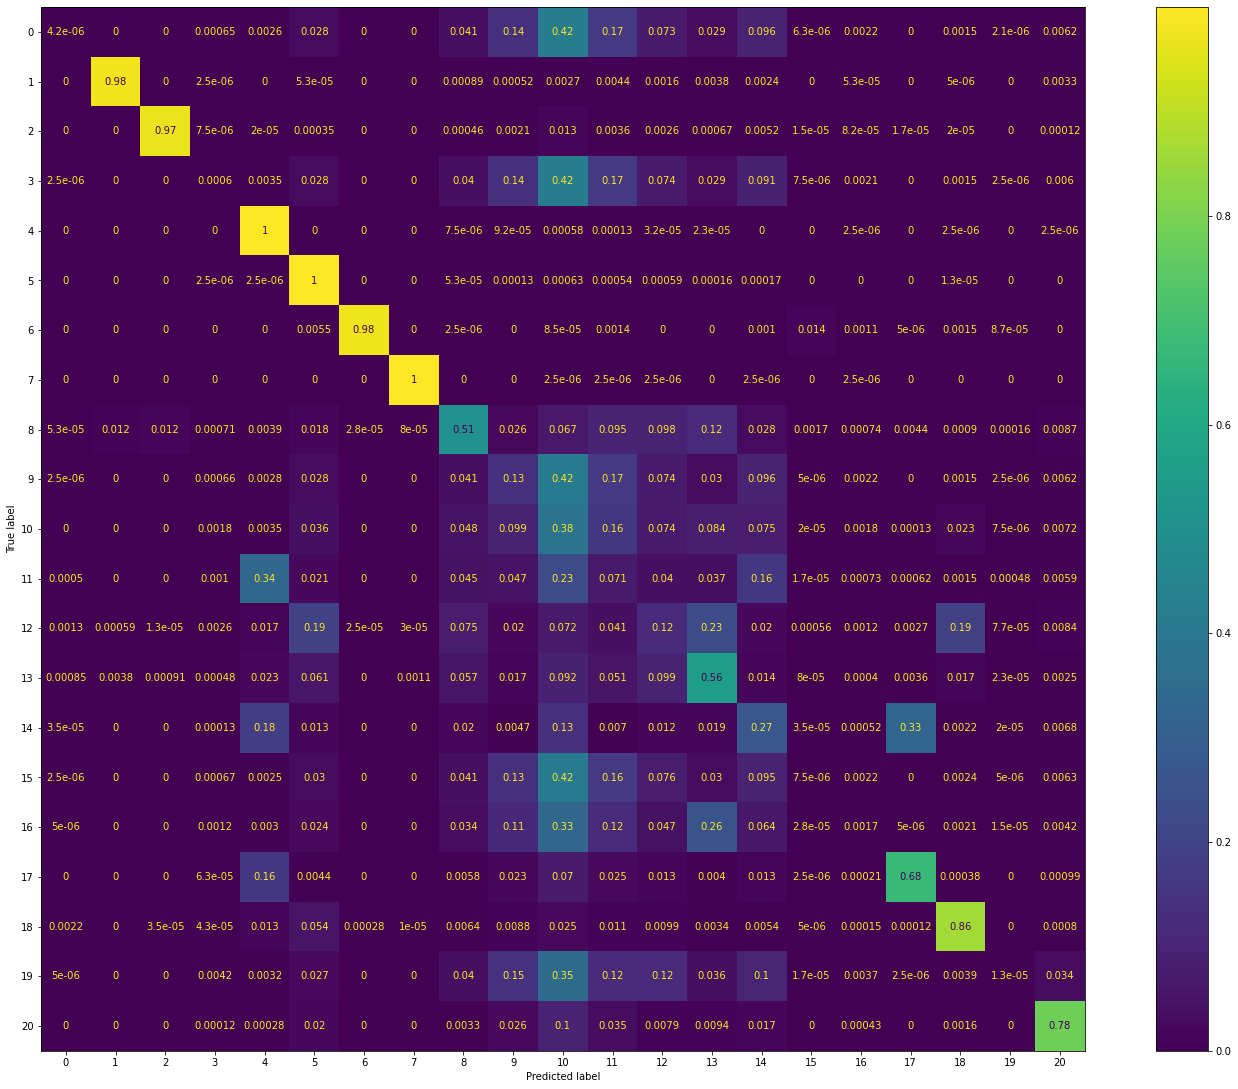

In [21]:
fig: plt.Figure = plt.figure(figsize=(6.4*4, 4.8*4))
ConfusionMatrixDisplay.from_predictions(y_data_test, y_pred, ax=fig.add_subplot(1, 1, 1), normalize='true')
plt.show()

In [32]:
dask_client.shutdown()
del dask_client